## Library Imports

In [37]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt

# ML tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Fairness
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate

# Transparency
import shap

## Data Loading and Preprocessing


The **UCI Adult Income dataset** is used to predict whether a person earns more than \$50K/year.  


The raw dataset requires preprocessing because:  
- It **has no headers**, so column names must be assigned.  
- It contains **categorical variables** (e.g. `workclass`, `education`, `occupation`) and the model expects numerical input.  
- It uses `?` for **missing values** that the model cannot handle directly.  


Preprocessing steps:  
1. Assign column names.  
2. Drop rows with missing values.  
3. Convert the target variable `income` to **binary classification** (0 = ≤50K, 1 = >50K).  
4. One-hot encode categorical features.  


The dataset is then ready for modelling.


In [38]:
# Define column names as UCI dataset has no headers
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

# Load dataset
data = pd.read_csv(
    'adult.data', 
    header=None, 
    names=column_names, 
    na_values='?', 
    sep=r',\s*', 
    engine='python'
)

# Drop rows with missing values
data.dropna(inplace=True)

# Convert target variable to binary format
data['income'] = (data['income'] == '>50K').astype(int)

# One-hot encode categorical variables
categorical_cols = [
    'workclass', 'education', 'marital-status',
    'occupation', 'relationship', 'race',
     'sex', 'native-country'
]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Split data into features and target variable
X = data.drop(['income', 'fnlwgt'], axis=1)
y = data['income']

print("Data preparation complete.")


Data preparation complete.


## Model Training


A **Logistic Regression classifier** is used as a starting point as it is simple, fast and works well for binary classification.


The dataset is split into **80% training data** and **20% testing data**.


**Feature scaling** is applied to help the model learn more efficiently (faster convergence) and produce more consistent results.


The model is trained on the scaled training data, and predictions (`y_pred`) are made on the test set.


The model's performance is measured using **accuracy**.


In [39]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialise Logistic Regression model
model = LogisticRegression(max_iter=5000, solver='lbfgs')
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate model
accuracy = model.score(X_test_scaled, y_test)

print(f"Model accuracy: {accuracy:.2f}")


Model accuracy: 0.85


The Logistic Regression model achieves around **85% accuracy** on the test set.
This serves as a baseline for testing other models and potential improvements.

## Fairness Audit

The model is audited for bias using the **Fairlearn** library. The audit focuses on sensitive features like sex and race to see if the model's predictions are fair.


- **MetricFrame** is used to group **accuracy** and **selection_rate** (how often >$50K predicted) for each group to measure the model's performance and outcome gaps.

- **Demographic Parity** is calculated to show the bias in positive outcomes between groups.

- **Equalised Odds** is calculated to see if the model is making errors at a similar rate across groups.

In [ ]:
def fairness_audit(sensitive_feature, feature_name):
    """
    Conducts and prints a fairness report on the model using the given sensitive feature.
     
     Args:
        sensitive_feature (pd.Series): The sensitive feature to audit (e.g. sex, race).
        feature_name (str): The name of the sensitive feature to print.
    """
    # Compute metrics by group
    metrics = MetricFrame(metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
                          y_true=y_test,
                          y_pred=y_pred,
                          sensitive_features=sensitive_feature)
    
    # Compute main fairness difference metrics
    dpd = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
    eod = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
    
    # Print a clear report
    print(f"--- Fairness Audit: {feature_name} ----\n")
    print("Performance and Selection Rates by Group:\n", metrics.by_group)
    print(f"\nDemographic Parity Difference (bias in outcomes): {dpd:.3f}")
    print(f"Equalised Odds Difference (bias in error rates): {eod:.3f}\n")

# Audit for sensitive features
sensitive_sex = data.loc[X_test.index, 'sex_Male']
sensitive_race = data.loc[X_test.index, 'race_White']

fairness_audit(sensitive_sex, "Sex")
fairness_audit(sensitive_race, "Race")

--- Fairness Audit: Sex ----

Performance and Selection Rates by Group:
           accuracy  selection_rate
sex_Male                          
False     0.928608        0.080571
True      0.815570        0.265963

Demographic Parity Difference (bias in outcomes): 0.185
Equalised Odds Difference (bias in error rates): 0.086

--- Fairness Audit: Race ----

Performance and Selection Rates by Group:
             accuracy  selection_rate
race_White                          
False       0.903151        0.123687
True        0.843895        0.219281

Demographic Parity Difference (bias in outcomes): 0.096
Equalised Odds Difference (bias in error rates): 0.038



### Fairness Audit Results

The results show a clear bias in how the model performs and its outcomes based on both sex and race.

- **Sex:** The model is more accurate at predicting income for females (92.9%) than for males (81.6%). The Demographic Parity Difference is high at **0.185**, which shows the model predicts a high income (>$50K) for men much more often than for women (26.6% vs 8.1%).

- **Race** The model is more accurate for non-white individuals (90.3%) than for white individuals (84.4%). Bias in outcomes is smaller but still present, with the Demographic Parity Diffrence **0.096** due to white individuals being predicted a high income more often than for non-white individuals (21.9% vs 12.4%).


**Conclusion:** The model is not fair for either group, as it appears to be replicating historical biases found in the 1994 data. 


## Transparency Audit

The fairness audit showed that the model is biased, but not why. The **SHAP** library is used to make the model's decisions more transparent. 

- **Global Explanations:** 
    - **Bar Chart** clearly shows which features have the greatest impact on average.
    - **Beeswarm Plot** gives more detail, showing direction and distribution of each feature's impact for every individual.

- **Local Explanation: Force Plot** to see reasons for an individual prediction.

SHAP bar chart: Shows the most important features for the model overall.

C:\Users\jenny\AppData\Local\Temp\ipykernel_6648\2971744670.py:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sample_renamed, plot_type="bar")


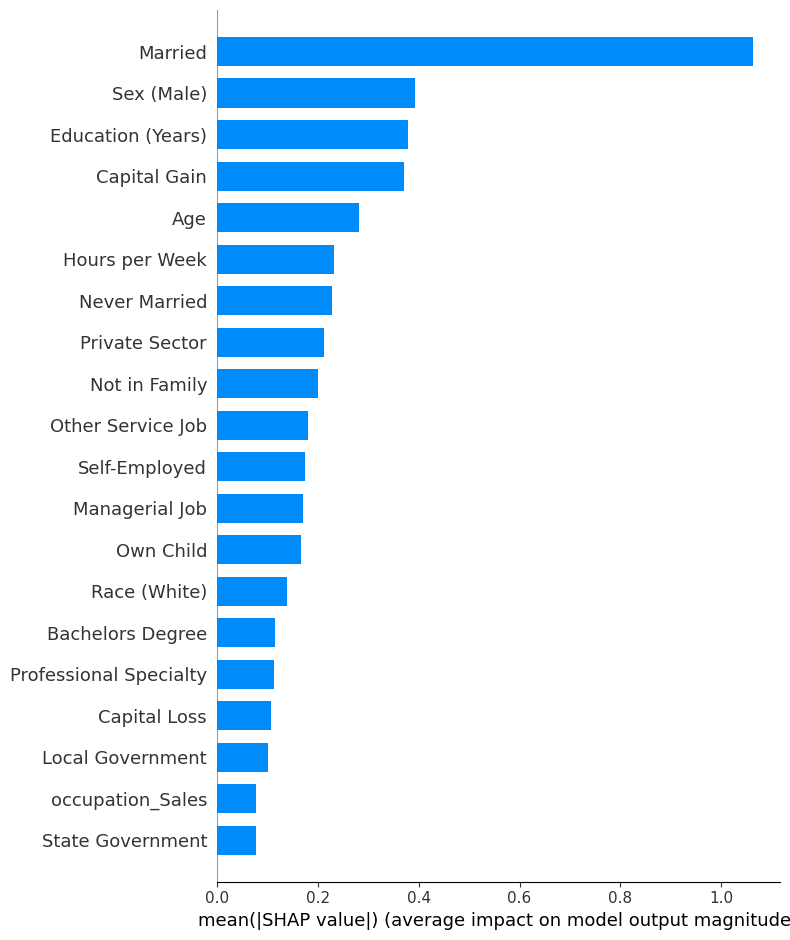

SHAP beeswarm plot: Shows impact and direction of each feature on predictions.


C:\Users\jenny\AppData\Local\Temp\ipykernel_6648\2971744670.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sample_renamed)


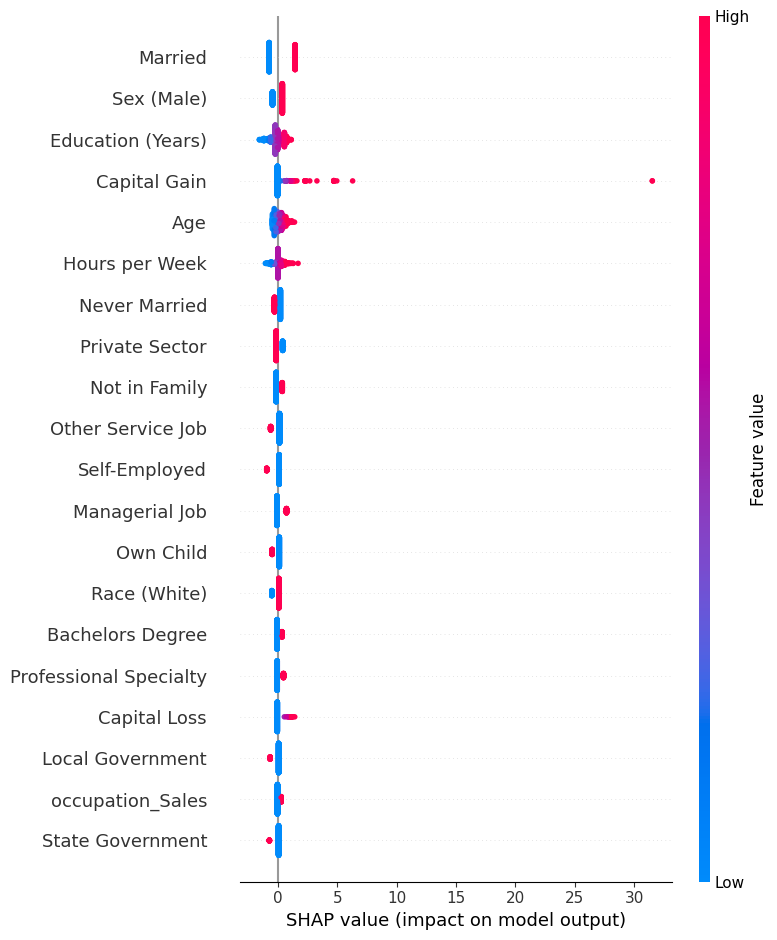

SHAP force plot: Explains a single prediction.


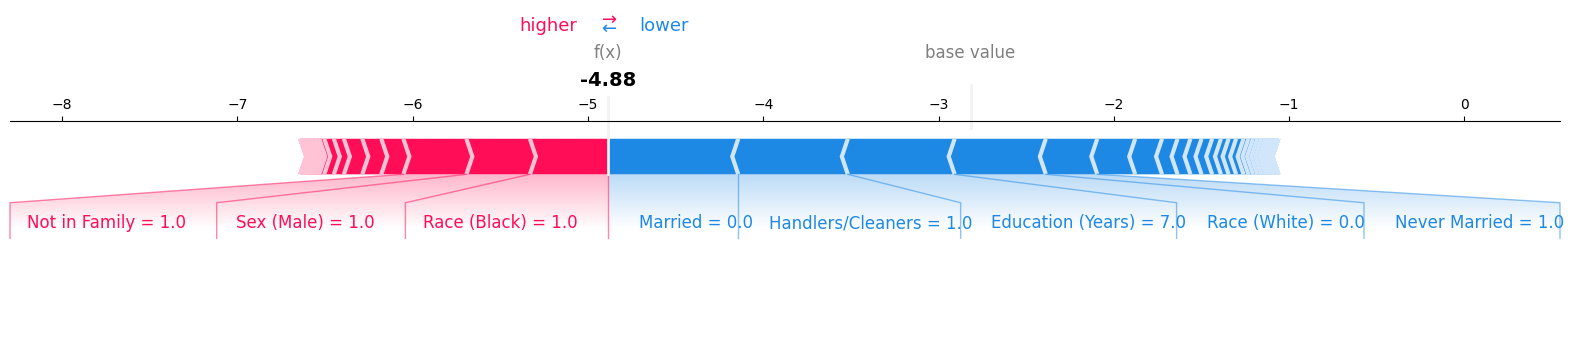

In [41]:
# Mapping for more readable names in SHAP plots
feature_names = {
    'marital-status_Married-civ-spouse': 'Married',
    'capital-gain': 'Capital Gain',
    'sex_Male': 'Sex (Male)',
    'education-num': 'Education (Years)',
    'age': 'Age',
    'marital-status_Never-married': 'Never Married',
    'workclass_Private': 'Private Sector',
    'hours-per-week': 'Hours per Week',
    'relationship_Not-in-family': 'Not in Family',
    'occupation_Other-service': 'Other Service Job',
    'workclass_Self-emp-not-inc': 'Self-Employed',
    'relationship_Own-child': 'Own Child',
    'occupation_Exec-managerial': 'Managerial Job',
    'race_White': 'Race (White)',
    'education_Bachelors': 'Bachelors Degree',
    'capital-loss': 'Capital Loss',
    'occupation_Prof-specialty': 'Professional Specialty',
    'relationship_Wife': 'Wife',
    'workclass_Local-gov': 'Local Government',
    'workclass_State-gov': 'State Government',
    'relationship_Unmarried': 'Unmarried',
    'occupation_Machine-op-inspct': 'Machine Operator',
    'race_Black': 'Race (Black)',
    'occupation_Handlers-cleaners': 'Handlers/Cleaners',
}

# Rename columns in X_test for SHAP plots
X_test_renamed = X_test.rename(columns=feature_names)

# Randomly sample 500 rows for SHAP analysis (scaled and unscaled)
rng = np.random.default_rng(seed=42) # For reproducibility
num_test_samples = X_test_scaled.shape[0]
random_indices = rng.choice(num_test_samples, 500, replace=False)
X_test_sample = X_test_scaled[random_indices]
X_test_sample_renamed = X_test_renamed.iloc[random_indices]

# Create SHAP explainer and compute SHAP values
explainer = shap.LinearExplainer(model, X_train_scaled)
shap_values = explainer.shap_values(X_test_sample)

print("SHAP bar chart: Shows the most important features for the model overall.")
shap.summary_plot(shap_values, X_test_sample_renamed, plot_type="bar")

print("SHAP beeswarm plot: Shows impact and direction of each feature on predictions.")
shap.summary_plot(shap_values, X_test_sample_renamed)

print("SHAP force plot: Explains a single prediction.")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_sample_renamed.iloc[0,:], matplotlib=True)

### Transparency Audit Findings

The SHAP analysis give clear insights into how the model behaves, explaining the bias found in the fairness audit.

- **Global Impact:** The bar chart and beeswarm plot show that `Married`, `Capital Gain` and `Education (Years)` are the most important features. The beeswarm plot shows being married pushes the prediction towards a higher income.

- **Local Prediction:** The force plot reveals how each feature pushed the prediction higher (red) or lower (blue) for this specific person, showing that being a `Handler/Cleaner` and `Never Married` were the strongest factors leading to their low-income prediction.

**Conclusion:** The SHAP plots help to explain the bias found fairness audit, showing the model is relying a lot on features closely linked to demographics, like marriage, to make its predictions. Next step is to analyse more individual force plots to gain more insight into the model's logic. 

